# Generating 2D bounding boxes for Poles like structures using semantic segmentation and polygons

## 1. Cloning repository to get images

In [1]:
%%capture
! git clone https://github.com/kar-ab/Labelling_utilities

In [2]:

import glob
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

root_dir = '/content/Labelling_utilities/cityscapes_dataset'

rgb_images = sorted(glob.glob(root_dir + '/*_leftImg8bit.png'))
print( len(rgb_images), 'RGB images are loaded')

sem_seg_images = sorted(glob.glob(root_dir + '/*_gtFine_color.png'))
print( len(sem_seg_images), 'Semantic Segmentation Images are loaded')

poly_files = sorted(glob.glob(root_dir + '/*.json'))
print( len(poly_files), 'Polygon files are loaded')

label_id_files = sorted(glob.glob(root_dir + '/*_gtFine_labelIds.png'))
print( len(label_id_files), 'Sem seg labels are loaded')

2 RGB images are loaded
2 Semantic Segmentation Images are loaded
2 Polygon files are loaded
2 Sem seg labels are loaded


## 2. Annotating Images

Text(0.5, 1.0, 'Shrinked BB on Sem Seg')

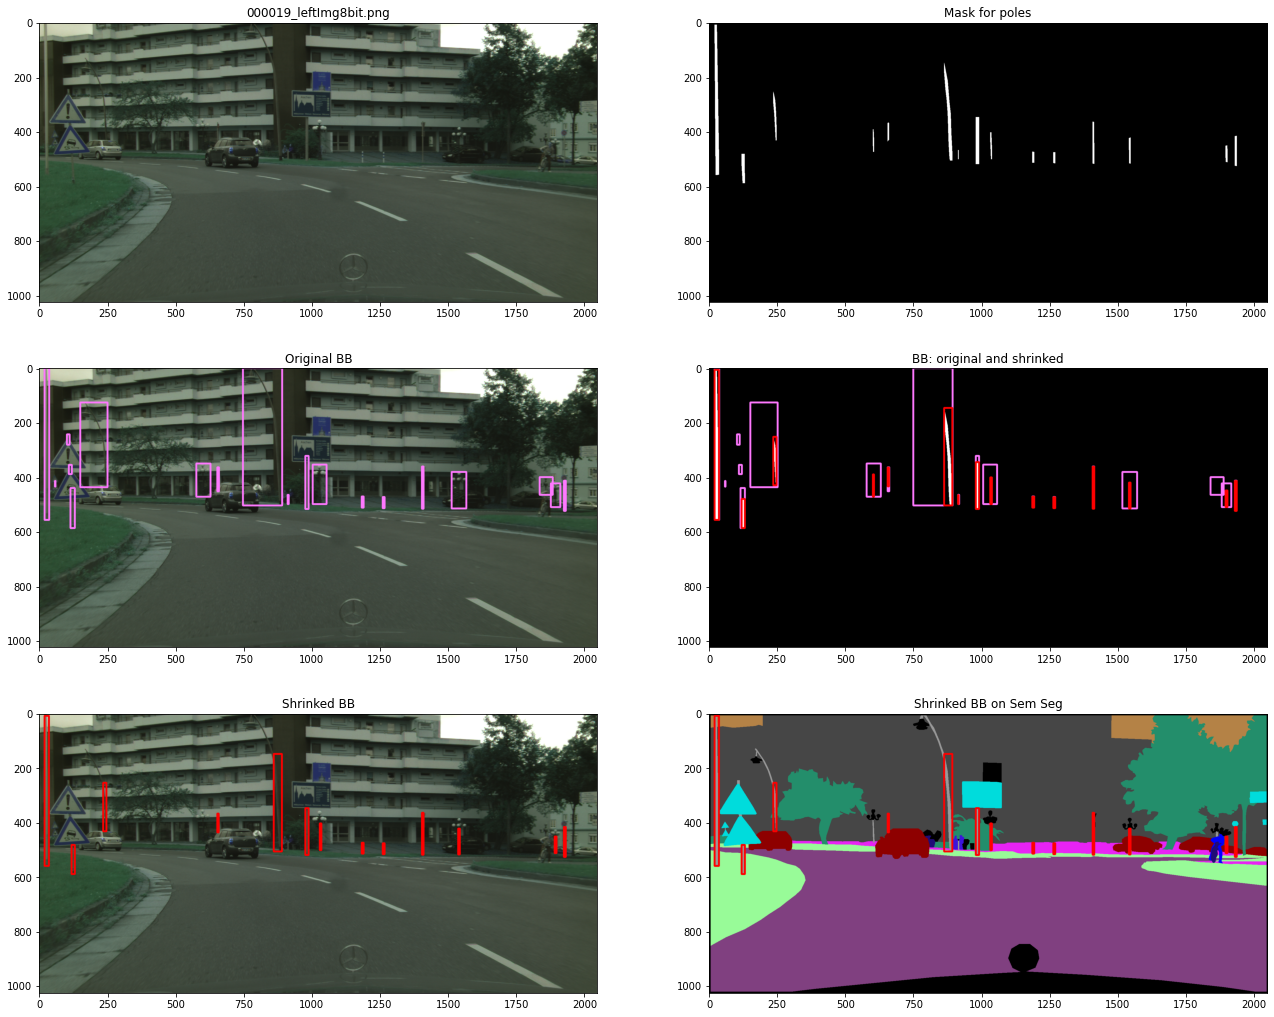

In [4]:
def annotation_pipeline(img, label_img, sem_seg_img, poly_file, min_ht_bounding_box, min_wd_bounding_box, max_wd_bounding_box): 
    with open(poly_file) as file:
        data = json.load(file)
        # print("Image Height:",data['imgHeight'])
        # print("Image widht:",data['imgWidth'])
        bb_array = np.empty([0,0], np.int32)
        bb_shrinked_array = np.empty([0,0], np.int32)
        
        img_bb = img.copy()
        img_bb_shrinked = img.copy()
        sem_seg_img_bb = sem_seg_img.copy()
        label_img_bb = label_img.copy()
        for object in data['objects']:
            # if object['label'] in ('traffic sign','pole'):
            if object['label'] in ('pole'):
                polygon = np.array(object['polygon'], np.int32)
                min_x = np.amin(polygon[:, 0]); min_y = np.amin(polygon[:, 1])
                max_x = np.amax(polygon[:, 0]); max_y = np.amax(polygon[:, 1])
                # print(object['polygon'])
                # print('min_x:',min_x, 'min_y:',min_y, 'max_x:',max_x, 'max_y:',max_y)
                # y values = poly_array[:, 1]; # x values = poly_array[:, 0]
 
                img_bb = cv2.rectangle(img_bb, (min_x,min_y), (max_x, max_y), (255,120,255), 5)
                label_img_bb = cv2.rectangle(label_img_bb, (min_x,min_y), (max_x, max_y), (255,120,255), 5)
                bb_array = np.append(bb_array, [(min_x,min_y), (max_x, max_y)])
                
                # shrinking bounding boxes
                
                filtered_pixels = np.empty([0,0], np.int32)
                for x in range(min_x, max_x+1):
                    for y in range(min_y, max_y+1):
                        if label_img[y][x][0] == 255:
                            if (len(filtered_pixels) == 0): 
                                filtered_pixels = np.append(filtered_pixels, np.array([x,y]))
                            else: 
                                filtered_pixels = np.vstack((filtered_pixels,np.array([x,y])))

                if (len(filtered_pixels)> 0):
                    filtered_min_x = np.amin(filtered_pixels[:, 0]); filtered_min_y = np.amin(filtered_pixels[:, 1])
                    filtered_max_x = np.amax(filtered_pixels[:, 0]); filtered_max_y = np.amax(filtered_pixels[:, 1])
                    label_img_bb = cv2.rectangle(label_img_bb, (filtered_min_x,filtered_min_y), (filtered_max_x, filtered_max_y), (255,0,0), 5)

                    if ( int(filtered_max_y - filtered_min_y) > min_ht_bounding_box and 
                        int(filtered_max_x - filtered_min_x) < max_wd_bounding_box and  # to reject pole groups(as their horizontal)
                        int(filtered_max_x - filtered_min_x) > min_wd_bounding_box ): 

                        sem_seg_img_bb = cv2.rectangle(sem_seg_img_bb, (filtered_min_x,filtered_min_y), (filtered_max_x, filtered_max_y), (255,0,0), 5)
                        img_bb_shrinked = cv2.rectangle(img_bb_shrinked, (filtered_min_x,filtered_min_y), (filtered_max_x, filtered_max_y), (255,0,0), 5)                    
                        bb_shrinked_array = np.append(bb_shrinked_array, [(filtered_min_x,filtered_min_y), (filtered_max_x, filtered_max_y)]) 
                       
    return img_bb, label_img_bb, img_bb_shrinked, sem_seg_img_bb, bb_array, bb_shrinked_array


index = 0
img = cv2.imread(rgb_images[index])
sem_seg_img = cv2.imread(sem_seg_images[index])
label_img = cv2.imread(label_id_files[index])
label_pole_img = np.zeros_like(label_img)
# 17 the label for poles
label_pole_img = np.where( label_img == 17 , 255, label_pole_img )

# https://docs.opencv.org/3.4/dd/dd7/tutorial_morph_lines_detection.html
rows = label_pole_img.shape[0]
verticalsize = rows // 30
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
# Apply morphology operations
label_pole_img = cv2.erode(label_pole_img, verticalStructure)
label_pole_img = cv2.dilate(label_pole_img, verticalStructure)


min_ht_bounding_box = 20
min_wd_bounding_box = 4
max_wd_bounding_box = 40

result = annotation_pipeline(img, label_pole_img, sem_seg_img, poly_files[index], min_ht_bounding_box, min_wd_bounding_box, max_wd_bounding_box)

'''
result tuple: 
img_bb, label_img_bb, img_bb_shrinked, sem_seg_img_bb, bb_array, bb_shrinked_array
'''

f, axarr = plt.subplots(3,2,figsize=(22, 18))
# Input Image
axarr[0, 0].imshow(img)
axarr[0, 0].set_title(str(rgb_images[index][-22:]) )
axarr[0, 1].imshow(label_pole_img)
axarr[0, 1].set_title('Mask for poles')

axarr[1, 0].imshow(result[0])
axarr[1, 0].set_title('Original BB')
axarr[1, 1].imshow(result[1])
axarr[1, 1].set_title('BB: original and shrinked')
# semantic segmentation
axarr[2, 0].imshow(result[2])
axarr[2, 0].set_title('Shrinked BB')
axarr[2, 1].imshow(result[3])
axarr[2, 1].set_title('Shrinked BB on Sem Seg')